In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [106]:
white_df = pd.read_csv('winequality-white.csv',delimiter=';')
white_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [107]:
red_df = pd.read_csv('winequality-red.csv', delimiter=';')
red_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [108]:
def add_quality_label(df):
    bins = (2, 5.5, 6.5, 8)
    group_names = ['low-quality', 'average-quality', 'high-quality']
    categories = pd.cut(df['quality'], bins, labels=group_names)
    df['quality_label'] = categories
    return df

In [109]:
white_df = add_quality_label(white_df)
red_df = add_quality_label(red_df)

In [110]:
white_df.quality_label.value_counts()

average-quality    2198
low-quality        1640
high-quality       1055
Name: quality_label, dtype: int64

In [111]:
red_df.quality_label.value_counts()

low-quality        744
average-quality    638
high-quality       217
Name: quality_label, dtype: int64

In [112]:
label_quality = LabelEncoder()

for wine in [red_df, white_df]:
    wine['quality_label'] = label_quality.fit_transform(wine['quality_label'])

In [113]:
white_df = white_df[white_df['quality_label'] != 3]

In [114]:
white_df.quality_label.value_counts()

0    2198
2    1640
1    1055
Name: quality_label, dtype: int64

In [115]:
# Separar las características de las etiquetas
X_red = red_df.drop(['quality', 'quality_label'], axis=1)
Y_red = red_df['quality_label']

In [116]:
X_white = white_df.drop(['quality', 'quality_label'], axis=1)
Y_white = white_df['quality_label']

In [117]:
# Realizar la división en conjuntos de entrenamiento y prueba
X_red_train, X_red_test, Y_red_train, Y_red_test = train_test_split(X_red, Y_red, test_size=0.2, random_state=42)
X_white_train, X_white_test, Y_white_train, Y_white_test = train_test_split(X_white, Y_white, test_size=0.2, random_state=42)

In [118]:
Y_white_train.value_counts()

0    1744
2    1321
1     849
Name: quality_label, dtype: int64

In [119]:
svm = SVC()
tree = DecisionTreeClassifier()
forest = RandomForestClassifier()

In [120]:
svm.fit(X_red_train, Y_red_train)

SVC()

In [121]:
for model, name in zip([svm, tree, forest], ['SVM', 'Decision Tree', 'Random Forest']):
    for wine, X_train, X_test, Y_train, Y_test in zip(['Red Wine', 'White Wine'], [X_red_train, X_white_train], [X_red_test, X_white_test], 
                                                       [Y_red_train, Y_white_train], 
                                                       [Y_red_test, Y_white_test]):
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        confusion = confusion_matrix(Y_test, predictions)
        scores = cross_val_score(model, X_test, Y_test, cv=10)
        print(f'{name} model average accuracy on {wine}: {scores.mean()}')
        print(f'Matriz de confusión para {name} en {wine}:\n{confusion}\n')

SVM model average accuracy on Red Wine: 0.503125
Matriz de confusión para SVM en Red Wine:
[[ 53   0  79]
 [ 30   1  16]
 [ 33   0 108]]

SVM model average accuracy on White Wine: 0.45659583420997263
Matriz de confusión para SVM en White Wine:
[[352   0 102]
 [185   0  21]
 [199   0 120]]

Decision Tree model average accuracy on Red Wine: 0.5375
Matriz de confusión para Decision Tree en Red Wine:
[[73 19 40]
 [14 26  7]
 [38  7 96]]

Decision Tree model average accuracy on White Wine: 0.5392909741216074
Matriz de confusión para Decision Tree en White Wine:
[[286  68 100]
 [ 73 115  18]
 [ 88  14 217]]

Random Forest model average accuracy on Red Wine: 0.6
Matriz de confusión para Random Forest en Red Wine:
[[ 86   9  37]
 [ 19  28   0]
 [ 31   1 109]]

Random Forest model average accuracy on White Wine: 0.6087839259415107
Matriz de confusión para Random Forest en White Wine:
[[346  34  74]
 [ 85 117   4]
 [ 77   3 239]]



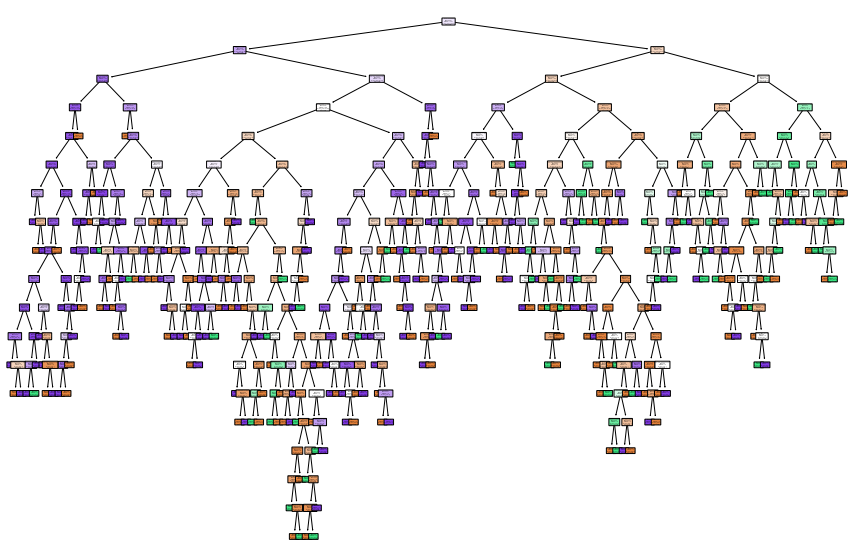

In [130]:
tree = DecisionTreeClassifier()
tree.fit(X_red_train, Y_red_train)

plt.figure(figsize=(15,10))
plot_tree(tree, 
          filled=True, 
          rounded=True, 
          feature_names=X_red.columns, 
          class_names=['low', 'average', 'high'])

plt.show()

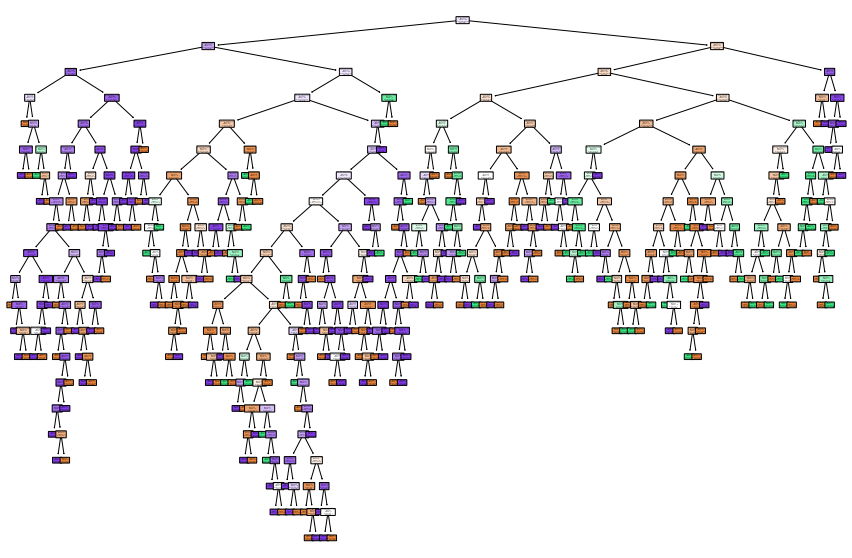

In [128]:
forest = RandomForestClassifier()
forest.fit(X_red_train, Y_red_train)

# Visualiza el primer árbol en el bosque
plt.figure(figsize=(15,10))
plot_tree(forest.estimators_[0], 
          filled=True, 
          rounded=True, 
          feature_names=X_red.columns, 
          class_names=['low', 'average', 'high'])
plt.show()

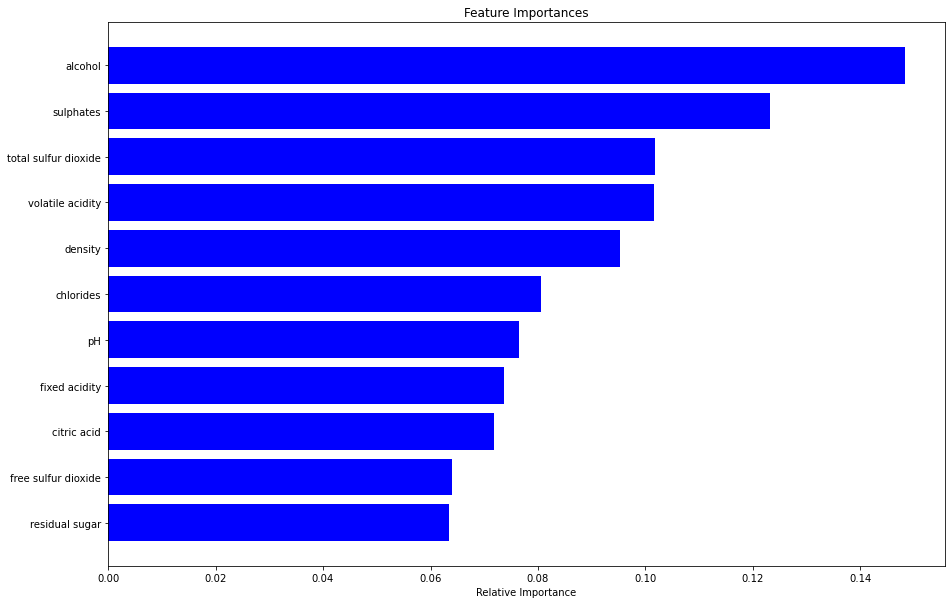

In [129]:
importances = forest.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(15,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_red.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()